# Notatki do pracowni drugiej

Rozwiązujemy układ równań

\begin{equation}
(x-x_1)^2 + (y-y_1)^2 + (z-z_1)^2 = \big[c(t_1-t)\big]^2 \\
(x-x_2)^2 + (y-y_2)^2 + (z-z_2)^2 = \big[c(t_2-t)\big]^2 \\
(x-x_3)^2 + (y-y_3)^2 + (z-z_3)^2 = \big[c(t_3-t)\big]^2 \\
(x-x_4)^2 + (y-y_4)^2 + (z-z_4)^2 = \big[c(t_4-t)\big]^2 \\
\end{equation}

Niech
\begin{equation}
f_i(x, y, z, t) = (x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2 - \big[c(t_i-t)\big]^2
\end{equation}

Z uogólnionego twierdzenia Taylora mamy
\begin{equation}
f_i(x + h_x, y + h_y, z + h_z, t + h_t) \approx f_i(x, y, z, t) + h_x \frac{\partial f_i}{\partial x}(x, y, z, t) 
+ h_y \frac{\partial f_i}{\partial y}(x, y, z, t) + h_z \frac{\partial f_i}{\partial z}(x, y, z, t)
+ h_t \frac{\partial f_i}{\partial t}(x, y, z, t)
\end{equation}

Ponadto
\begin{equation}
\frac{\partial f_i}{\partial x} = 2(x-x_i) \\
\frac{\partial f_i}{\partial y} = 2(y-y_i) \\
\frac{\partial f_i}{\partial z} = 2(z-z_i) \\
\frac{\partial f_i}{\partial t} = -2c^2(t-t_i)
\end{equation}

Stąd
\begin{equation}
f_i(x + h_x, y + h_y, z + h_z, t + h_t) \approx f_i(x, y, z, t) + 2h_x(x-x_i) + 2h_y(y-y_i) + 2h_z(z-z_i) -2c^2h_t(t-t_i)
\end{equation}

## Metoda Newtona

Zastosujemy metodę Newtona. Chcemy znaleźć $x, y, z, t$, dla których $f_i(x, y, z, t) = 0$ dla $1 \leq i \leq 4$.
Niech $x_n \in \mathbb{R}^4$ będzie n-tym przybliżeniem metody Newtona. Szukamy $h \in \mathbb{R}^4$, takiego że
dla $x_{n+1} = x_n + h$ zajdzie $f_i(x_{n+1}) = 0$ dla $1 \leq i \leq 4$.

Niech
$$
x_n = 
    \begin{pmatrix}
    x \\
    y \\
    z \\
    t
    \end{pmatrix}
$$

Rozwiążemy układ równań
\begin{equation}
0 = f_1(x, y, z, t) + 2h_x(x-x_1) + 2h_y(y-y_1) + 2h_z(z-z_1) -2c^2h_t(t-t_1) \\
0 = f_2(x, y, z, t) + 2h_x(x-x_2) + 2h_y(y-y_2) + 2h_z(z-z_2) -2c^2h_t(t-t_2) \\
0 = f_3(x, y, z, t) + 2h_x(x-x_3) + 2h_y(y-y_3) + 2h_z(z-z_3) -2c^2h_t(t-t_3) \\
0 = f_4(x, y, z, t) + 2h_x(x-x_4) + 2h_y(y-y_4) + 2h_z(z-z_4) -2c^2h_t(t-t_4)
\end{equation}
Inaczej
\begin{equation}
\begin{pmatrix}
x-x_1  & y-y_1 & z-z_1 & -c^2(t-t_1) \\
x-x_2  & y-y_2 & z-z_2 & -c^2(t-t_2) \\
x-x_3  & y-y_3 & z-z_3 & -c^2(t-t_3) \\
x-x_4  & y-y_4 & z-z_4 & -c^2(t-t_4) \\
\end{pmatrix}
\begin{pmatrix}
h_x \\ h_y \\ h_z \\ h_t
\end{pmatrix}
=
-\frac{1}{2}
\begin{pmatrix}
f_1(x, y, z, t) \\
f_2(x, y, z, t) \\
f_3(x, y, z, t) \\
f_4(x, y, z, t)
\end{pmatrix}
\end{equation}

Wtedy 
$$
x_{n+1} = x_n + h = x_n + \begin{pmatrix} h_x \\ h_y \\ h_z \\ h_t \end{pmatrix}
$$

In [33]:
function fsingle(x, sat)
    c = 299792.458
    a = (x - sat) .^ 2
    a[4] *= -c^2
    sum(a)
end

function fvect(x, sats)
    [fsingle(x, sats[i]) for i = 1:length(sats)]
end

function getcoeffs(x, sats)
    c = 299792.458
    A = [x - sats[i] for i = 1:length(sats)]
    A = hcat(A...)'
    A[:, 4] *= -c^2
    A
end

function newton(sats,  maxiter::Int64)
    c = 299792.458
    x = [0, 0, 6370, 0]
    for i = 1:maxiter
        A = getcoeffs(x, sats)
        B = fvect(x, sats)
        h = -0.5 * (A \ B)
        x = x + h
    end
    x
end;

In [34]:
using Polynomials

function algebraic(sats)
    c = 2.99792458
    x = [sat[1:3] for sat in sats]
    t = [sat[4] for sat in sats]
    A = hcat([x[i] - x[4] for i = 1:3]...)'
    B = c^2 * (t[1:3] .- t[4])
    sum4 = sum(x[4] .^ 2)
    C = -0.5 * [ c^2*(t[i]^2 - t[4]^2) - sum(x[i] .^ 2) + sum4 for i = 1:3]
    
    a = A \ B
    b = A \ C
    bdiff = b - x[4]
    
    coeffs = Array{Float64}(3)
    coeffs[1] = sum(bdiff .^ 2) - c^2*t[4]^2
    coeffs[2] = 2*(sum(a .* bdiff) + c^2*t[4])
    coeffs[3] = sum(a) - c^2
    guesses = filter(x -> isreal(x), roots(Poly(coeffs)))
    
    location = vcat([a[i]*guesses[1] + b[i] for i = 1:3], guesses[1])
    if(length(guesses) > 1)
        location2 = vcat([a[i]*guesses[2] + b[i] for i = 1:3], guesses[2])
        if(sum(abs2, location2) < sum(abs2, location))
            location = location2
        end
    end
    
    vcat(location[1:3]*10^2, location[4]/10^3)
    end; 

In [35]:
function prepsat!(x, sat; newton::Bool=true)
    c = 299792.458
    if(!newton)
        c = 2.99792458
    end
    for i = 1:length(sat)
        sat[i][4] = norm(x[1:3]-sat[i][1:3]) / c + x[4]
    end
end

function toalgebraic(sat; onedim::Bool=false)
    newsat = deepcopy(sat)
    if(onedim)
        newsat[4] *= 10^3
        newsat[1:3] /= 10^2
    else 
        for i = 1:length(sat)
            newsat[i][4] *= 10^3
            newsat[i][1:3] /= 10^2
        end
    end
    newsat
end

sat = Array{Array{Float64}}(4)
satalg = Array{Array{Float64}}(4)

sat[1] = [15600.0, 7540.0, 20140.0, 7.074e-2]
sat[2] = [18760.0, 2750.0, 18610.0, 7.220e-2]
sat[3] = [17610.0, 14630.0, 13480.0, 7.690e-2]
sat[4] = [19170.0, 610.0, 18390.0, 7.242e-2]

satalg = toalgebraic(sat)

println(newton(sat, 15))
println(algebraic(satalg))

x = [123.456789, -1234.123, 6300.5392, 5.67e-4]
prepsat!(x, sat)
prepsat!(toalgebraic(x, onedim=true), satalg, newton=false)
println(newton(sat, 15))
println(algebraic(satalg))

x = [12.823234, 3.1231233, -7.12387623, 9.43e-3]
prepsat!(x, sat)
prepsat!(toalgebraic(x, onedim=true), satalg, newton=false)
println(newton(sat, 15))
println(algebraic(satalg)) 

[-41.7727, -16.7892, 6370.06, -0.00320157]
[-41.7726, -16.7955, 6369.21, -0.00319148]
[123.457, -1234.12, 6300.54, 0.000567]
[123.456, -1234.12, 6300.52, 0.000567278]
[12.8232, 3.12312, -7.12388, 0.00943]
[12.8183, 3.12112, -7.12717, 0.0094324]


In [36]:
using PyPlot

NEWTON
BIGGEST MISTAKE : 28.25607056180391 meters


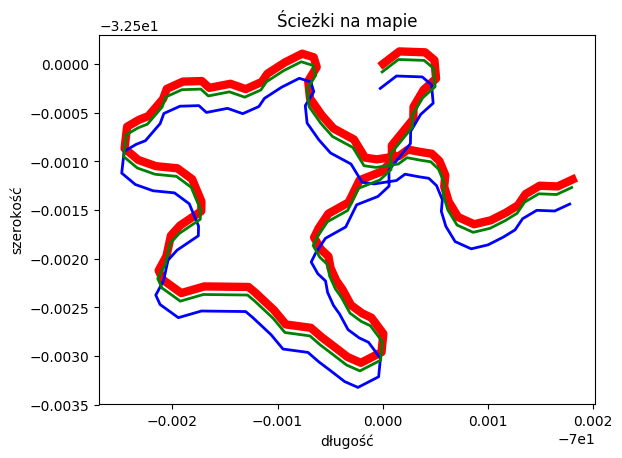

SMALLEST MISTAKE : 28.250465184013017 meters
ALGEBRAIC
BIGGEST MISTAKE : 9.276285676510955 meters
SMALLEST MISTAKE : 9.274601460601945 meters


In [90]:
function randSgn()
    x = rand(0:1)
    if x==0
        return -1
    else
        return 1
    end
end

function path(maxiter, lon0, lat0)
    a = pi/4
    d = 0.000005
    lon = lon0 + d*cos(a)
    lat = lat0 + d*sin(a)
    t=0
    res = [[], []]
    for i in 1:maxiter
        push!(res[1], lon)
        push!(res[2], lat)
        if t==0
            t = rand(20:50)
            da = rand()*randSgn()
            a +=da
        end
        lon += d*cos(a)
        lat += d*sin(a)
        t-=1
    end
    res
end

function LLAtoXYZ(LL)
    rad = 6378.1
    lon = LL[1]
    lat = LL[2]
    cosLat = cos(lat * pi / 180.0)
    sinLat = sin(lat * pi / 180.0)
    cosLon = cos(lon * pi / 180.0)
    sinLon = sin(lon * pi / 180.0)
    x = rad * cosLat * cosLon
    y = rad * cosLat * sinLon
    z = rad * sinLat
    [x, y, z]
end

function XYZtoLLA(X)
    rad = 6378.1
    x = X[1]
    y = X[2]
    z = X[3]
    lat = asin(z / rad) * 180 / pi
    lon = atan(y / x) * 180 / pi
    return [lon, lat]
end

function countTime(mistake, Pos, sat)
    C = 299792.458
    dist = sqrt(sum( [ (Pos[i]-sat[i])^2 for i in 1:3]))
    t = dist / C
    return [t + mistake]
end


sat1 = [15600,7540,20140]
sat2 = [18760,2750,18610]
sat3 = [17610,14630,13480]
sat4 = [19170,610,18390]

function createSats(lon, lat, mistake)
    sat = Array{Array{Float64}}(4)
    sat[1] = vcat(sat1, countTime(mistake, LLAtoXYZ([lon, lat]), sat1) )
    sat[2] = vcat(sat2, countTime(mistake, LLAtoXYZ([lon, lat]), sat2) )
    sat[3] = vcat(sat3, countTime(mistake, LLAtoXYZ([lon, lat]), sat3) )
    sat[4] = vcat(sat4, countTime(mistake, LLAtoXYZ([lon, lat]), sat4) )
    sat
end

function GPS_newton(coords, mistake, maxiter)
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = createSats(coords[1][i], coords[2][i], mistake)
        X = newton(sat, maxiter)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function GPS_alg(coords, mistake)
    res = [[],[]]
    for i in 1:length(coords[1])
        sat = toalgebraic( createSats(coords[1][i], coords[2][i], mistake) )
        X = algebraic(sat)
        LL = XYZtoLLA(X[1:3])
        push!(res[1], LL[1])
        push!(res[2], LL[2])
    end
    return res
end

function MAXdist(coords, gps)
    res = 0.0
    for i in 1:length(coords[1])
        X1 = LLAtoXYZ([coords[1][i], coords[2][i]])
        X2 = LLAtoXYZ([gps[1][i], gps[2][i]])
        d =sqrt(sum([(X1[i]-X2[i])^2   for i in 1:3] ))
        res = max(res, d)
    end
    return res*1000
end

function MINdist(coords, gps)
    res = 100000.0
    for i in 1:length(coords[1])
        X1 = LLAtoXYZ([coords[1][i], coords[2][i]])
        X2 = LLAtoXYZ([gps[1][i], gps[2][i]])
        d =sqrt(sum([(X1[i]-X2[i])^2   for i in 1:3] ))
        res = min(res, d)
    end
    return res*1000
end

coords = path(3000, -70, -32.5)
x = coords[1]
y = coords[2]

mistake = 0.001

newton_coords = GPS_newton(coords, mistake, 3)
xn = newton_coords[1]
yn = newton_coords[2]

alg_coords = GPS_alg(coords, mistake)
xa = alg_coords[1]
ya = alg_coords[2]

fig, ax = subplots()

title("Ścieżki na mapie")
xlabel("długość")
ylabel("szerokość")
ax[:plot](x, y, "-", color="red", linewidth=6, alpha=1.0)
ax[:plot](xn, yn, "-", color="blue", linewidth=2, alpha=1.0)
ax[:plot](xa, ya, "-", color="green", linewidth=2, alpha=1.0)
show()


println("NEWTON")
println("BIGGEST MISTAKE : ", MAXdist(coords, newton_coords), " meters")
println("SMALLEST MISTAKE : ", MINdist(coords, newton_coords), " meters")
println("ALGEBRAIC")
println("BIGGEST MISTAKE : ", MAXdist(coords, alg_coords), " meters")
println("SMALLEST MISTAKE : ", MINdist(coords, alg_coords), " meters")


In [88]:
function alg_mistake_plot(coords, maxiter)
    res = [[], []]
    dm = 0.00005
    mistake = 0.0
    for i in 1:maxiter
        alg_coords = GPS_alg(coords, mistake)
        dist = MAXdist(coords, alg_coords)
        push!(res[1], mistake)
        push!(res[2], dist)
        mistake+=dm
    end
    res
end
show()

Maksymalny błąd gpsa w zależności od błędu zegara

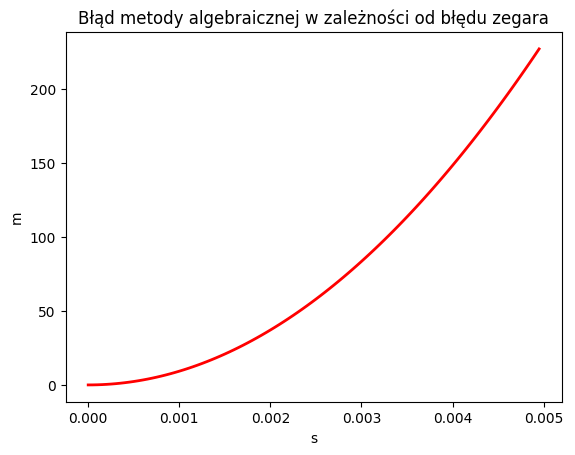

In [85]:
data = alg_mistake_plot(coords, 100)
x = data[1]
y = data[2]

fig, ax = subplots()

title("Błąd metody algebraicznej w zależności od błędu zegara")
ylabel("m")
xlabel("s")
ax[:plot](x, y, "-", color="red", linewidth=2, alpha=1.0)
show()

maksymalny błąd metody newtona w zależnosći od liczby iteracji

In [100]:
function newton_mistake_plot(coords, maxiter)
    res = [[], []]
    for i in 1:maxiter
        newton_coords = GPS_newton(coords, 0.005, i)
        dist = MAXdist(coords, newton_coords)
        push!(res[1], i)
        push!(res[2], dist)
    end
    return res
end
show()

In [101]:
data = newton_mistake_plot(coords, 10)
x = data[1]
y = data[2]

for i in 1:10
    println(x[i], " : ", y[i])
end

1 : 312107.3783412224
2 : 13409.485158955737
3 : 22.069822721112228
4 : 6.0735330921711305e-5
5 : 9.998370291970441e-7
6 : 9.736017589984019e-7
7 : 9.066511836933177e-7
8 : 9.118521546919904e-7
9 : 1.0930437197543144e-6
10 : 1.1186773047189584e-6
